In [1]:
# Required package installations
!pip install tensorflow scikit-learn scikeras xgboost imbalanced-learn keras-tuner


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

# Import necessary libraries
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [3]:

# Function to get performance metrics
def get_metrics(y_test, y_pred, y_pred_proba=None):
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=1),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        metrics['ROC AUC'] = auc(fpr, tpr)
    return metrics

In [4]:
# Data loading and initial processing
data = pd.read_csv('C:/Users/Sedem Kofi Amediku/Downloads/bs140513_032310.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [5]:
# Create two dataframes with fraud and non-fraud data
df_fraud = data.loc[data.fraud == 1]
df_non_fraud = data.loc[data.fraud == 0]

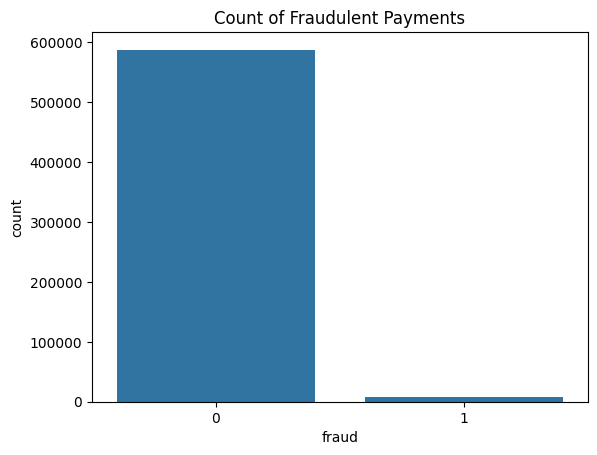

Number of normal examples:  587443
Number of fraudulent examples:  7200


In [6]:
# Plot count of fraudulent payments
sns.countplot(x="fraud", data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ", df_non_fraud.fraud.count())
print("Number of fraudulent examples: ", df_fraud.fraud.count())

In [7]:
# Feature engineering and preprocessing
print("Unique zipCodeOri values: ", data.zipcodeOri.nunique())
print("Unique zipMerchant values: ", data.zipMerchant.nunique())
data_reduced = data.drop(['zipcodeOri', 'zipMerchant'], axis=1)

col_categorical = data_reduced.select_dtypes(include=['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category').cat.codes

X = data_reduced.drop(['fraud'], axis=1)
y = data['fraud']

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


In [8]:
# Balance the dataset using SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res, columns=['fraud'])
print(y_res['fraud'].value_counts())

fraud
0    587443
1    587443
Name: count, dtype: int64


In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, shuffle=True, stratify=y_res)


In [10]:
# Function for plotting ROC_AUC curve
def plot_roc_auc(y_test, preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [11]:
# The base score should be better than predicting always non-fraudulent
print("Base accuracy score we must beat is: ", df_non_fraud.fraud.count() / np.add(df_non_fraud.fraud.count(), df_fraud.fraud.count()) * 100)


Base accuracy score we must beat is:  98.7891894800746


c:\Users\Sedem Kofi Amediku\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Classification Report for K-Nearest Neighbors: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    176233
           1       0.97      1.00      0.98    176233

    accuracy                           0.98    352466
   macro avg       0.98      0.98      0.98    352466
weighted avg       0.98      0.98      0.98    352466

Confusion Matrix of K-Nearest Neighbors: 
 [[170992   5241]
 [   528 175705]]


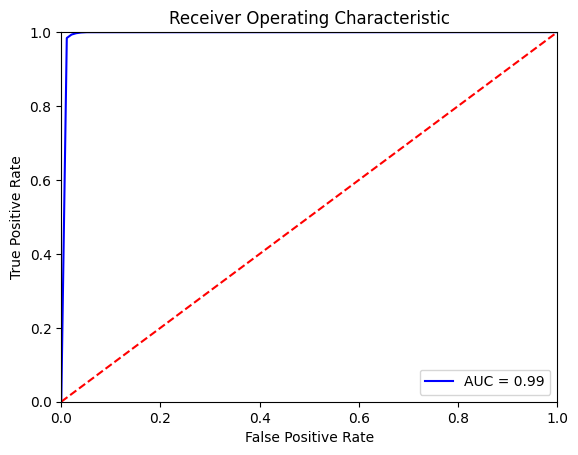

KNN Metrics: {'Accuracy': 0.9836324638404839, 'Precision': 0.9710355575696616, 'Recall': 0.9970039663400158, 'F1 Score': 0.9838484345384246, 'ROC AUC': 0.9940863498990454}


In [12]:
# K-Nearest Neighbors without hyperparameter tuning
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("Classification Report for K-Nearest Neighbors: \n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix of K-Nearest Neighbors: \n", confusion_matrix(y_test, y_pred_knn))
plot_roc_auc(y_test, knn.predict_proba(X_test)[:, 1])
# Calculate and display metrics for KNN
knn_metrics = get_metrics(y_test, y_pred_knn, knn.predict_proba(X_test)[:, 1])
print(f"KNN Metrics: {knn_metrics}")

c:\Users\Sedem Kofi Amediku\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    176233
           1       0.97      1.00      0.98    176233

    accuracy                           0.98    352466
   macro avg       0.98      0.98      0.98    352466
weighted avg       0.98      0.98      0.98    352466

Confusion Matrix of Random Forest Classifier: 
 [[170985   5248]
 [   783 175450]]


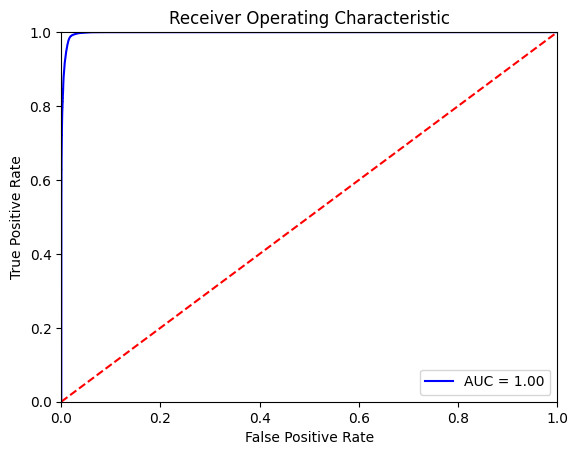

Random Forest Metrics: {'Accuracy': 0.9828891297316621, 'Precision': 0.970957066486624, 'Recall': 0.9955570182655916, 'F1 Score': 0.9831031768044804, 'ROC AUC': 0.9980723544494905}


In [13]:
# Random Forest Classifier without hyperparameter tuning
rf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test, y_pred_rf))
plot_roc_auc(y_test, rf.predict_proba(X_test)[:, 1])
# Calculate and display metrics for Random Forest
rf_metrics = get_metrics(y_test, y_pred_rf, rf.predict_proba(X_test)[:, 1])
print(f"Random Forest Metrics: {rf_metrics}")

Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    176233
           1       0.98      0.99      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of XGBoost: 
 [[172667   3566]
 [  1210 175023]]


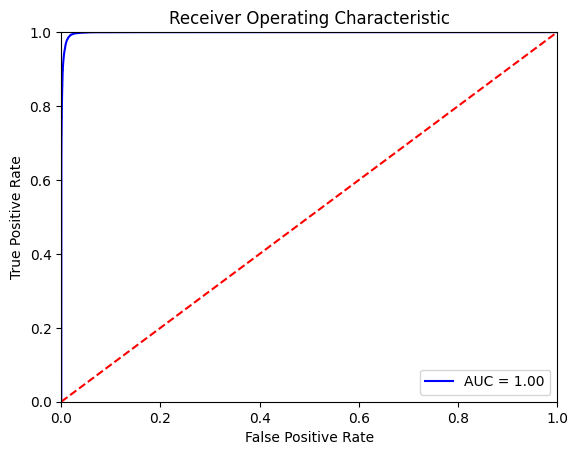

XGBoost Metrics: {'Accuracy': 0.9864497568559805, 'Precision': 0.9800323648153022, 'Recall': 0.9931340895292028, 'F1 Score': 0.9865397297800024, 'ROC AUC': 0.998733936119208}


In [14]:
# XGBoost Classifier without hyperparameter tuning
xgb_clf = xgb.XGBClassifier(objective="binary:logistic", learning_rate=0.05, n_estimators=200, max_depth=5, random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test, y_pred_xgb))
plot_roc_auc(y_test, xgb_clf.predict_proba(X_test)[:, 1])
# Calculate and display metrics for XGBoost
xgb_metrics = get_metrics(y_test, y_pred_xgb, xgb_clf.predict_proba(X_test)[:, 1])
print(f"XGBoost Metrics: {xgb_metrics}")

In [15]:
# Deep Learning Model with LSTM and ADASYN
data = pd.read_csv('C:/Users/Sedem Kofi Amediku/Downloads/bs140513_032310.csv')
data = data.drop(['zipcodeOri', 'zipMerchant'], axis=1)
for col in col_categorical:
    data[col] = data[col].astype('category').cat.codes
X = data.drop('fraud', axis=1)
y = data['fraud']
ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_resample(X, y)
scaler = StandardScaler()
X_res = scaler.fit_transform(X_res)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [16]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(BatchNormalization())
lstm_model.add(LSTM(32, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(BatchNormalization())
lstm_model.add(Dense(1, activation='sigmoid'))

In [17]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping], verbose=1)
loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Epoch 1/50


10275/10275 [==============================] - 41s 3ms/step - loss: 0.1648 - accuracy: 0.9439 - val_loss: 0.1097 - val_accuracy: 0.9630
Epoch 2/50
10275/10275 [==============================] - 31s 3ms/step - loss: 0.1318 - accuracy: 0.9577 - val_loss: 0.1003 - val_accuracy: 0.9654
Epoch 3/50
10275/10275 [==============================] - 31s 3ms/step - loss: 0.1245 - accuracy: 0.9601 - val_loss: 0.0980 - val_accuracy: 0.9660
Epoch 4/50
10275/10275 [==============================] - 31s 3ms/step - loss: 0.1197 - accuracy: 0.9614 - val_loss: 0.0915 - val_accuracy: 0.9687
Epoch 5/50
10275/10275 [==============================] - 31s 3ms/step - loss: 0.1173 - accuracy: 0.9621 - val_loss: 0.0883 - val_accuracy: 0.9689
Epoch 6/50
10275/10275 [==============================] - 30s 3ms/step - loss: 0.1135 - accuracy: 0.9632 - val_loss: 0.0846 - val_accuracy: 0.9712
Epoch 7/50
10275/10275 [==============================] - 30s 3ms/step - loss: 0.1107 - accuracy: 0.9638 - val_loss

11009/11009 [==============================] - 13s 1ms/step


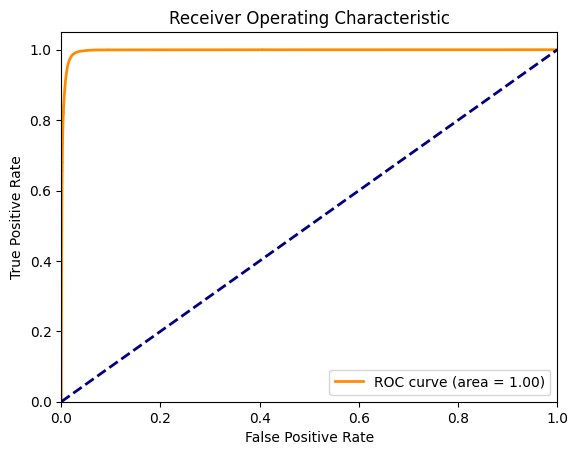

In [18]:
y_pred_proba = lstm_model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [19]:
# Calculate and display metrics for LSTM
lstm_metrics = get_metrics(y_test, (y_pred_proba > 0.5).astype(int), y_pred_proba)
print(f"LSTM Metrics: {lstm_metrics}")

# CNN + LSTM with ADASYN
adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X, y)
scaler = StandardScaler()
X_res = scaler.fit_transform(X_res)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)
X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(Dropout(0.5))
cnn_lstm_model.add(BatchNormalization())
cnn_lstm_model.add(LSTM(64, return_sequences=True))
cnn_lstm_model.add(Dropout(0.5))
cnn_lstm_model.add(BatchNormalization())
cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(Dense(64, activation='relu'))
cnn_lstm_model.add(Dropout(0.5))
cnn_lstm_model.add(Dense(1, activation='sigmoid'))

cnn_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = cnn_lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping], verbose=1)
loss, accuracy = cnn_lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

LSTM Metrics: {'Accuracy': 0.981364149904337, 'Precision': 0.9717159684260919, 'Recall': 0.9915703371297111, 'F1 Score': 0.9815427609105758, 'ROC AUC': 0.9969930162780144}

Epoch 1/50
10275/10275 [==============================] - 51s 5ms/step - loss: 0.1679 - accuracy: 0.9412 - val_loss: 0.1041 - val_accuracy: 0.9643
Epoch 2/50
10275/10275 [==============================] - 49s 5ms/step - loss: 0.1243 - accuracy: 0.9591 - val_loss: 0.0939 - val_accuracy: 0.9672
Epoch 3/50
10275/10275 [==============================] - 49s 5ms/step - loss: 0.1145 - accuracy: 0.9622 - val_loss: 0.0899 - val_accuracy: 0.9698
Epoch 4/50
10275/10275 [==============================] - 49s 5ms/step - loss: 0.1103 - accuracy: 0.9635 - val_loss: 0.0826 - val_accuracy: 0.9705
Epoch 5/50
10275/10275 [==============================] - 49s 5ms/step - loss: 0.1065 - accuracy: 0.9652 - val_loss: 0.0817 - val_accuracy: 0.9715
Epoch 6/50
10275/10275 [==============================] - 49s 5ms/step - loss: 0.1040 - accu

11009/11009 [==============================] - 16s 1ms/step


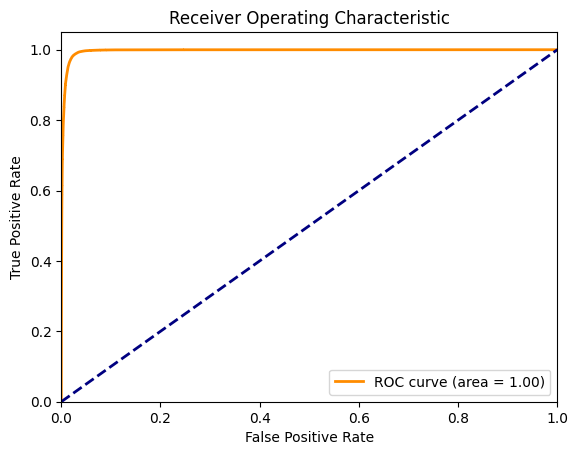

In [20]:
y_pred_proba = cnn_lstm_model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [21]:
# Calculate and display metrics for CNN + LSTM
cnn_lstm_metrics = get_metrics(y_test, (cnn_lstm_model.predict(X_test).ravel() > 0.5).astype(int), cnn_lstm_model.predict(X_test).ravel())
print(f"CNN + LSTM Metrics: {cnn_lstm_metrics}")

11009/11009 [==============================] - 16s 1ms/step
CNN + LSTM Metrics: {'Accuracy': 0.9794963068939871, 'Precision': 0.9691063687895966, 'Recall': 0.9905478712829107, 'F1 Score': 0.9797098192339566, 'ROC AUC': 0.9967412063669722}


Epoch 1/50
10275/10275 [==============================] - 17s 2ms/step - loss: 0.1872 - accuracy: 0.9360 - val_loss: 0.1108 - val_accuracy: 0.9635
Epoch 2/50
10275/10275 [==============================] - 17s 2ms/step - loss: 0.1419 - accuracy: 0.9555 - val_loss: 0.1047 - val_accuracy: 0.9648
Epoch 3/50
10275/10275 [==============================] - 17s 2ms/step - loss: 0.1378 - accuracy: 0.9571 - val_loss: 0.1012 - val_accuracy: 0.9658
Epoch 4/50
10275/10275 [==============================] - 17s 2ms/step - loss: 0.1361 - accuracy: 0.9577 - val_loss: 0.1005 - val_accuracy: 0.9668
Epoch 5/50
10275/10275 [==============================] - 16s 2ms/step - loss: 0.1355 - accuracy: 0.9578 - val_loss: 0.1019 - val_accuracy: 0.9659
Epoch 6/50
10275/10275 [==============================] - 16s 2ms/step - loss: 0.1334 - accuracy: 0.9587 - val_loss: 0.1009 - val_accuracy: 0.9657
Epoch 7/50
10275/10275 [==============================] - 17s 2ms/step - loss: 0.1323 - accuracy: 0.9589 - val_loss: 0

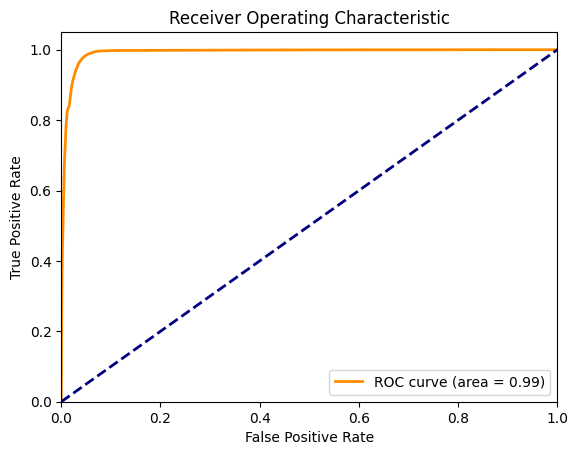

In [22]:
# Feedforward Neural Network (FNN) with ADASYN
adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X, y)
scaler = StandardScaler()
X_res = scaler.fit_transform(X_res)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

fnn_model = Sequential()
fnn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
fnn_model.add(Dropout(0.5))
fnn_model.add(BatchNormalization())
fnn_model.add(Dense(32, activation='relu'))
fnn_model.add(Dropout(0.5))
fnn_model.add(BatchNormalization())
fnn_model.add(Dense(1, activation='sigmoid'))

fnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = fnn_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping], verbose=1)
loss, accuracy = fnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

y_pred_proba = fnn_model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [23]:
# Calculate and display metrics for FNN
fnn_metrics = get_metrics(y_test, (fnn_model.predict(X_test).ravel() > 0.5).astype(int), fnn_model.predict(X_test).ravel())
print(f"FNN Metrics: {fnn_metrics}")

11009/11009 [==============================] - 9s 829us/step
FNN Metrics: {'Accuracy': 0.9667620458842164, 'Precision': 0.9492411319599353, 'Recall': 0.9862251128972706, 'F1 Score': 0.9673797670421146, 'ROC AUC': 0.9916577753046913}


11009/11009 [==============================] - 9s 834us/step


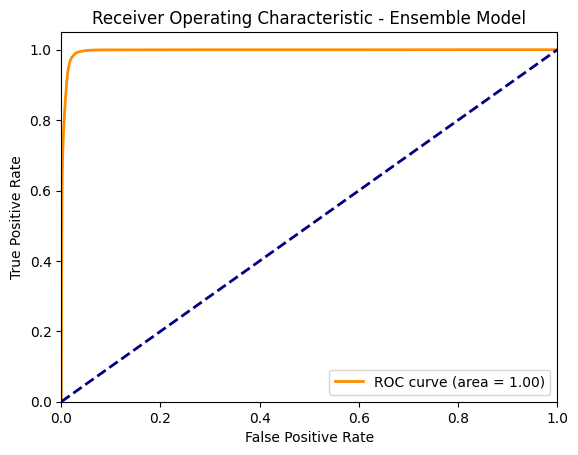

Classification Report for Ensemble Model: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    176233
           1       0.97      0.99      0.98    176045

    accuracy                           0.98    352278
   macro avg       0.98      0.98      0.98    352278
weighted avg       0.98      0.98      0.98    352278

Confusion Matrix of Ensemble Model: 
 [[170476   5757]
 [  1307 174738]]
Ensemble Metrics: {'Accuracy': 0.9799476549770352, 'Precision': 0.9681043796227042, 'Recall': 0.992575761879065, 'F1 Score': 0.9801873562573624, 'ROC AUC': 0.9962804488216539}


In [24]:
# Ensemble Model
classifiers = [
    ('LSTM', lstm_model),
    ('CNN_LSTM', cnn_lstm_model),
    ('FNN', fnn_model)
]

def ensemble_predict(X):
    predictions = np.zeros((X.shape[0], len(classifiers)))
    for i, (name, clf) in enumerate(classifiers):
        if name == 'LSTM' or name == 'CNN_LSTM':
            if name == 'LSTM':
                X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))  # LSTM expects (samples, timesteps, features)
            else:
                X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))  # CNN_LSTM expects (samples, features, channels)
            predictions[:, i] = clf.predict(X_reshaped).ravel()
        else:
            predictions[:, i] = clf.predict(X).ravel()
    return np.mean(predictions, axis=1)

y_pred_ensemble_proba = ensemble_predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ensemble_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Ensemble Model')
plt.legend(loc="lower right")
plt.show()

y_pred_ensemble = (y_pred_ensemble_proba > 0.5).astype(int)
print("Classification Report for Ensemble Model: \n", classification_report(y_test, y_pred_ensemble))
print("Confusion Matrix of Ensemble Model: \n", confusion_matrix(y_test, y_pred_ensemble))
# Calculate and display metrics for Ensemble Model
ensemble_metrics = get_metrics(y_test, y_pred_ensemble, y_pred_ensemble_proba)
print(f"Ensemble Metrics: {ensemble_metrics}")

In [25]:
# Create a DataFrame to summarize the results
results_df = pd.DataFrame([knn_metrics, rf_metrics, xgb_metrics, lstm_metrics, cnn_lstm_metrics, fnn_metrics, ensemble_metrics],
                          index=['KNN', 'Random Forest', 'XGBoost', 'LSTM', 'CNN_LSTM', 'FNN', 'Ensemble'])

# Display the summary table
from IPython.display import display

print("Model Performance Summary:\n")
display(results_df)

# Save the summary table as a CSV file
results_df.to_csv('model_performance_summary.csv', index=True)

# Save the models if needed
lstm_model.save('lstm_model.h5')
cnn_lstm_model.save('cnn_lstm_model.h5')
fnn_model.save('fnn_model.h5')

# Clean up resources if necessary
import gc
gc.collect()

# End of script
print("All tasks completed.")

Model Performance Summary:



,Accuracy,Precision,Recall,F1 Score,ROC AUC
KNN,0.983632,0.971036,0.997004,0.983848,0.994086
Random Forest,0.982889,0.970957,0.995557,0.983103,0.998072
XGBoost,0.986450,0.980032,0.993134,0.986540,0.998734
LSTM,0.981364,0.971716,0.991570,0.981543,0.996993
CNN_LSTM,0.979496,0.969106,0.990548,0.979710,0.996741
FNN,0.966762,0.949241,0.986225,0.967380,0.991658
Ensemble,0.979948,0.968104,0.992576,0.980187,0.996280


c:\Users\Sedem Kofi Amediku\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


All tasks completed.


In [26]:
import joblib

# Save the ensemble model
joblib.dump(classifiers, 'ensemble_model.pkl')


INFO:tensorflow:Assets written to: C:\Users\SEDEMK~1\AppData\Local\Temp\tmp1i55yqml\assets


INFO:tensorflow:Assets written to: C:\Users\SEDEMK~1\AppData\Local\Temp\tmp1i55yqml\assets


INFO:tensorflow:Assets written to: C:\Users\SEDEMK~1\AppData\Local\Temp\tmpv7zhk3w2\assets


INFO:tensorflow:Assets written to: C:\Users\SEDEMK~1\AppData\Local\Temp\tmpv7zhk3w2\assets


INFO:tensorflow:Assets written to: C:\Users\SEDEMK~1\AppData\Local\Temp\tmpnxekfhpp\assets


INFO:tensorflow:Assets written to: C:\Users\SEDEMK~1\AppData\Local\Temp\tmpnxekfhpp\assets


['ensemble_model.pkl']

In [27]:
# Save the XGBoost model
xgb_clf.save_model('xgb_model.bin')

# Load the XGBoost model
xgb_clf = xgb.XGBClassifier()
xgb_clf.load_model('xgb_model.bin')

c:\Users\Sedem Kofi Amediku\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
